## Simulation Bouncing-Ball Q-Learning

In [1]:
# Laden von notwendigen Paketen
import malbrid
import gymnasium as gym
from gym import spaces
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time

In [2]:
# Klasse mit allen notwendigen Ploting-Funktionen 
class plotDynamic:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.line1, = self.ax.plot([], [], 'r-', label='Ball')
        self.line2, = self.ax.plot([], [], 'b-', label='Paddle')
        self.ax.set_xlabel('Time')
        self.ax.set_ylabel('Height')
        plt.ion()  # Turn on interactive mode
        # plt.get_current_fig_manager().full_screen_toggle()

    def small_plot(self, x, y1, y2):
        self.line1.set_xdata(x)
        self.line1.set_ydata(y1)
        self.line2.set_xdata(x)
        self.line2.set_ydata(y2)

        self.ax.relim()
        self.ax.autoscale_view()

        plt.draw()
        plt.pause(0.001)

    def saveGraph(self, name):
        plt.savefig(str(name), dpi=300)

    def show(self):
        plt.ioff()  # Turn off interactive mode
        plt.show()

### 1. Erstellung der Umgebung

In [3]:
# Initialisierung des Simulators
simulator = malbrid.LinearSystemSimulator(["x", "xspeed", "p", "t", "const"])

# Definition der Farben der graphischen Oberfläsche
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
scaling_factor = 4

random.seed(1234)
np.random.seed(1234)

# Hier wird die Dynamik der Umgebung definiert
def get_dynamics_and_zero_crossing_functions_controller(state_name):
    ATimeCount = np.array([[0, 0, 1]])

    x = simulator.get_var("x")
    t = simulator.get_var("t")

    def nobumpUp(x):
        return "Go", np.array([x[0], 0, x[2]]), False

    def nobumpDown(x):
        return "End", np.array([x[0], 0, x[2]]), False

    def nobumpStill(x):
        return "Wait", np.array([x[0], 0, x[2]]), False

    if state_name == "Wait":
        zero_crossing_end_up = x <= 1
        return ATimeCount, [(zero_crossing_end_up, "GoUp", nobumpUp)]
    if state_name == "Go":
        zero_crossing_end_up = t >= 0.5
        return ATimeCount, [(zero_crossing_end_up, "GoDown", nobumpDown)]
    if state_name == "End":
        zero_crossing_end_up = t >= 0.5
        return ATimeCount, [(zero_crossing_end_up, "GoStill", nobumpStill)]
    else:
        raise Exception("Internal Test error:" + str(state_name))

# Dynamik des Paddles
def get_dynamics_and_zero_crossing_functions_system(state_name):
    APaddleDown = np.array([[0, 1, 0, 0], [0, 0, 0, -9.81], [0, 0, 0, -1], [0, 0, 0, 0]], dtype=np.float64)
    APaddleUp = np.array([[0, 1, 0, 0], [0, 0, 0, -9.81], [0, 0, 0, 1], [0, 0, 0, 0]], dtype=np.float64)
    APaddleStill = np.array([[0, 1, 0, 0], [0, 0, 0, -9.81], [0, 0, 0, 0], [0, 0, 0, 0]], dtype=np.float64)

    x = simulator.get_var("x")
    xs = simulator.get_var("xspeed")
    p = simulator.get_var("p")

    def bumpPaddleUp(x):
        return "PaddleUp", np.array([x[0], -0.9 * x[1] + 0.9, x[2], x[3]]), False

    def bumpPaddleDown(x):
        return "PaddleDown", np.array([x[0], -0.9 * x[1] - 0.9, x[2], x[3]]), False

    def bumpPaddleStill(x):
        return "PaddleStill", np.array([x[0], -0.9 * x[1], x[2], x[3]]), False

    def nobumpPaddleToUp(x):
        return "PaddleUp", np.array([x[0], x[1], x[2], x[3]]), False

    def nobumpPaddleToDown(x):
        return "PaddleDown", np.array([x[0], x[1], x[2], x[3]]), False

    def nobumpPaddleToStill(x):
        return "PaddleStill", np.array([x[0], x[1], x[2], x[3]]), False

    if state_name == "PaddleUp":
        zero_crossing_end_up = simulator.get_true_condition()
        zero_crossing_bump = (x <= p) & (xs < 1)
        return APaddleUp, [(zero_crossing_end_up, "GoDown", nobumpPaddleToDown), (zero_crossing_bump, "bump", bumpPaddleUp)]
    if state_name == "PaddleDown":
        zero_crossing_end_up = simulator.get_true_condition()
        zero_crossing_bump = (x <= p) & (xs < -1)
        return APaddleDown, [(zero_crossing_end_up, "GoStill", nobumpPaddleToStill), (zero_crossing_bump, "bump", bumpPaddleDown)]
    if state_name == "PaddleStill":
        zero_crossing_end_up = simulator.get_true_condition()
        zero_crossing_bump = (x <= p) & (xs < 0) & (~zero_crossing_end_up)
        return APaddleStill, [(zero_crossing_end_up, "GoUp", nobumpPaddleToUp), (zero_crossing_bump, "bump", bumpPaddleStill)]
    else:
        raise Exception("Internal Test error:" + str(state_name))

product_dynamics = malbrid.compute_product_dynamics(
    [("x", 1, [0, 1]), ("xspeed", 1, [1]), 
    ("p", 1, [1]), ("t", 0, [0]), ("const", 1, [0, 1])],
    get_dynamics_and_zero_crossing_functions_controller,
    get_dynamics_and_zero_crossing_functions_system, ["GoUp", "GoDown", "GoStill"]
)

# Erstellung der Umgebung mithilfe von Gymnasium
class BouncingBallEnv(gym.Env):
    def __init__(self):
        super(BouncingBallEnv, self).__init__()
        
        # Definition des Aktions- Zustandsraums
        self.action_space = spaces.Discrete(3)  # Drei Aktionen: oben, unten, stehen bleiben
        self.observation_space = spaces.Box(
            low=np.array([-10, -10, -10]), 
            high=np.array([10, 10, 10]),
            dtype=np.float32
        )
        self.mvt = "PaddleStill"
        self.ctrl = "Wait"

        self.trace_time = []
        self.trace_states_ball = []
        self.trace_states_paddle = []
        
        self.reset()

    def reset(self):
        self.state = np.array([10.0, 0, 0, 0, 1.0])
        self.time_step = 0  

        self.trace_time = []
        self.trace_states_ball = []
        self.trace_states_paddle = []

        return self.state

    # Definition einer Belohnungsfunktion
    def sigmoid(self, x):
        return 1 / (1 + math.exp(-(x-5))) # Die Ausgänge der Funktion liegen in [0,1]
    
    def calculateReward(self, state, action, previous_action):
        reward = 0
        threshold = 5 # Schwellenwert, über dem der Ball immer aufspringen muss 

        distance = state[0] - threshold
        reward = 2*self.sigmoid(distance)

        # Bestraffung, wenn der Agent die gleiche Aktion auswählt (außer stehen bleiben).
        if action == previous_action and action != 0:
            reward -= 0.1

        return reward
    
    def step(self, action, previous_action):
        if action == 0:
            self.mvt = "PaddleStill"
            self.ctrl = "Wait"
        elif action == 1:
            self.mvt = "PaddleDown"
            self.ctrl = "End"
        else:
            self.mvt = "PaddleUp"
            self.ctrl = "Go"

        # Simulation eines Zeitschritts
        simulator.simulate(product_dynamics, (self.ctrl, self.mvt), self.state, max_time= 0.01)

        # Neue Zustände werden eingesammelt
        self.state = simulator.continuous_states[-1]
        time_points = simulator.time_points[-1]
        reward = 0

        self.trace_time.append(self.time_step)
        self.trace_states_ball.append(self.state[0]) # Stelle des Balls
        self.trace_states_paddle.append(self.state[2]) # Stelle des Paddles
        
        # Berechnung von der Belohnung
        if self.state[2] < 0:
            self.state[2] = 0
            reward = -0.01  # Betraffung, wenn der Agent versuch, den Paddle unter 0 zu schieben
        else:
            reward = self.calculateReward(self.state, action, previous_action) 
        
        # Prüfe, ob die Simulation fertig ist
        done = False
        if self.time_step >= 200.0:
            done = True
            print("End with Time : ", self.time_step)
        
        self.time_step += time_points

        return self.state, reward, done, {}

    # Die drei untere Funktionen werden eingeschaltet, um eine visuelle Darstellung der simulation zu haben
    # Momentan funktionniert nicht gut wegen Synchronization mit hoher Anzahl von Ausgängen
    def render(self, mode='human'):
        self.window.fill(WHITE)
        position_ball = self.state[0]
        position_paddle = self.state[2]
        self.render_state(self.window, position_ball, position_paddle)
        pygame.display.flip()
    
    def close(self):
        pygame.quit()

    # def render_state(self, window, position_ball, position_paddle):
    #     paddle_width = 0.2
    #     paddle_height = 10

    #     y_pos = int(position_ball)
    #     x_pos = window.get_height() // 2
    #     y_pos_paddle = int(position_paddle)
    #     x_pos_paddle = window.get_height() // 2

    #     pygame.draw.circle(window, BLACK, (x_pos, window.get_height() - (y_pos * scaling_factor + window.get_width() * 0.2)), 10)
    #     y_screen = window.get_height() - paddle_height - int(y_pos_paddle)
    #     pygame.draw.rect(window, BLACK, (x_pos_paddle - (paddle_width / 2), window.get_height() - (y_pos_paddle * scaling_factor - 10 + window.get_width() * 0.2), int(paddle_width * window.get_width() * 0.4), paddle_height))

### 2. Q-Learning Algorithmus zum Trainieren des Agenten

In [4]:
def q_learning(env, num_episodes, alpha, gamma, epsilon):
    # nicht möglich, normales q_learning im kontinuierlichen Raum zu verwenden.
    # Stattdessen wird eine Funktionsannäherung verwendet. In diesem Fall geht es um die Diskretisierung der Umgebung.
    # 1 000 Bins werden für die Diskretisierung erstellt.
    
    q_table = np.zeros((1001, env.action_space.n)) 
    rewards = []
    
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        
        done = False
        old_action = None
        discret_state = int(round((state[0])*100, 0))
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[discret_state])  # Exploit learned values
            
            next_state, reward, done, _ = env.step(action, old_action)
            
            old_value = q_table[discret_state][action]
            next_max = np.max(q_table[int(round((next_state[0])*100, 0))])
            
            # Haupt-Gleichung: Q-learning 
            q_table[discret_state][action] = old_value + alpha * (reward + gamma * next_max - old_value)
            
            state = next_state
            total_reward += reward
            old_action = action
            
        rewards.append(total_reward)

        # Darstellung der Dynamik des Balls und des Paddles
        plotObj = plotDynamic()
        plotObj.small_plot(env.trace_time, env.trace_states_ball, env.trace_states_paddle) 
        
        plotObj.show()
        # plotObj.saveGraph("dynamic_"+str(episode)+".pdf")
    
    return q_table, rewards

### 3. Ausführung und Anzeige der Ergebnisse

/home/deameni/dev/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


End with Time :  200.00771837891875


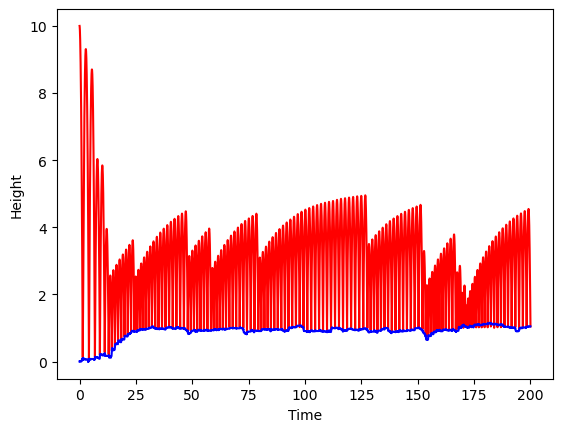

End with Time :  200.01255535328622


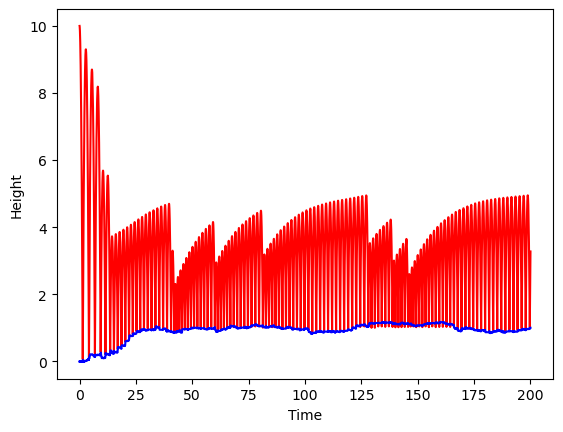

End with Time :  200.01129615723147


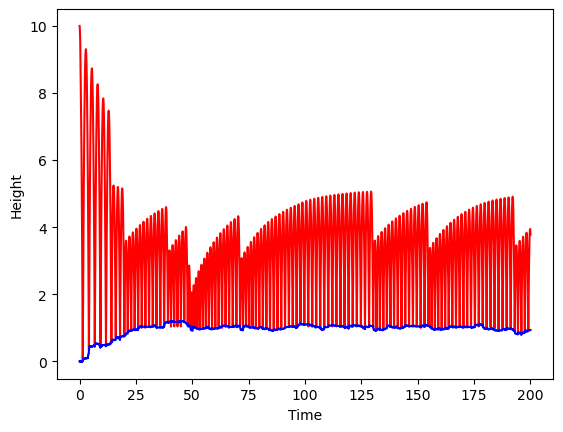

End with Time :  200.00096907544003


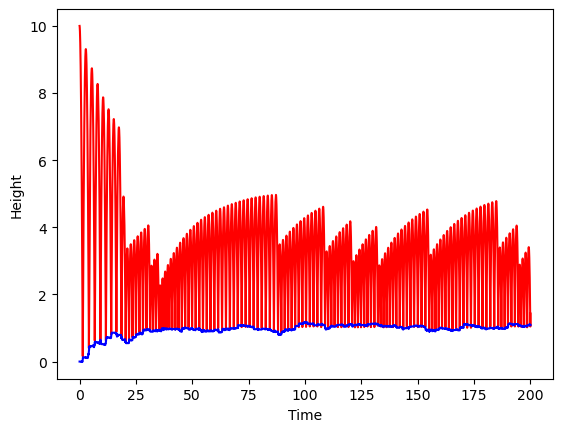

End with Time :  200.00144734427337


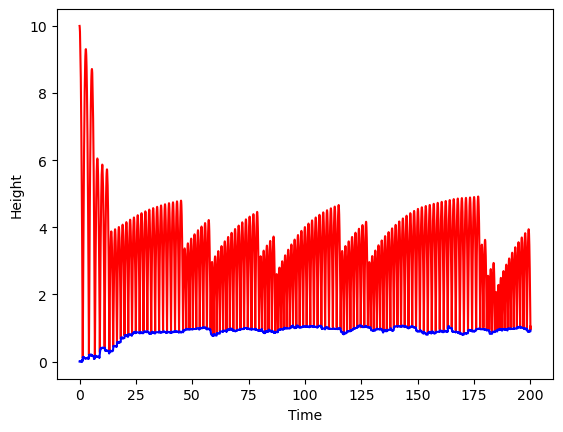

Simulation done!
[97.25205807051653, 111.59471010499915, 130.63878758184134, 131.43932798583288, 100.91877820854796]


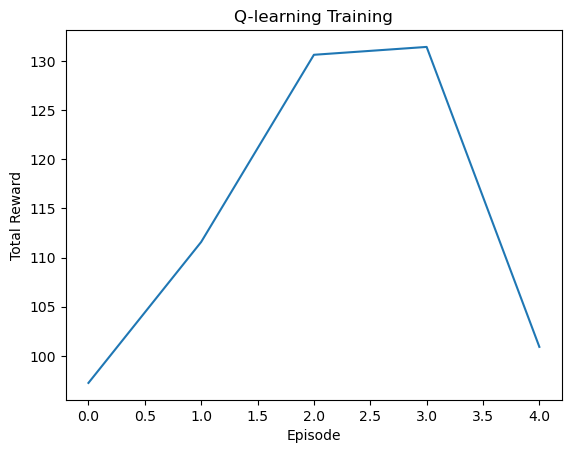

In [5]:
# Initializierung der Umgebung
env = BouncingBallEnv()
# plotObj = plotDynamic()

# Train the agent
num_episodes = 5
alpha = 0.1  # Learning rate
gamma = 0.99  # Diskontfaktor
epsilon = 0.1  # Erkundungsfaktor

q_table, rewards = q_learning(env, num_episodes, alpha, gamma, epsilon)
print("Simulation done!")

print(rewards)
# print(q_table)

# Darstellung der Belohnung
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning Training')
plt.show()

# env.close() # auskommentiert, weil keine GUI eingerichtet wurde.